# Modulo - Exp

Setting up the basic experiment that counteracts the Weka experiment.

In [9]:
import PxW
import pandas as pd
import arff
import os
import numpy as np
from os.path import dirname

RANDOM_STATE = 42

from modulo.core import Modulo
from modulo.visuals import show_diagram



In [10]:
def filename(basename, step=1, prefix="", suffix="", extension="arff", check=True):
    
    filename = "-".join([x for x in (prefix, basename, suffix) if len(x) > 0])+".{}".format(extension)
    
    root_dir = dirname(os.getcwd())
    data_dir = os.path.relpath(os.path.join(root_dir, 'data'))
    step_dir = os.path.join(data_dir, "step-"+str(step).zfill(2))

    if check:
        if not os.path.exists(step_dir):
            os.makedirs(step_dir)
    

    return os.path.join(step_dir, filename)

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import f1_score


def f1_weka(out, average='macro'):
    out = out.apply(LabelEncoder().fit_transform)
    f1 = f1_score(out['actual'], out['predicted'], average=average)
    return f1


def arff_to_df(filename, encode_nominal=False, return_af=True):
    with open(filename, 'r') as f:
        af = arff.load(f, encode_nominal=encode_nominal)
    
    df = pd.DataFrame(af['data'])
    
    if return_af:
        return df, af
    else:
        return df

In [3]:
def qry_from_df(df):
    qry = np.zeros(len(df.columns), dtype=int)
    miss_ids = df.columns[df.isna().any()].tolist()
    targ_ids = df.columns[-1]
    
    qry[miss_ids] = -1
    qry[targ_ids] = 1
    return qry

In [4]:
def fn_to_ok_df(filename, return_qry=True):
    """
    Convenience function. Preprocess so its ready for sklearn.
    """
    
    df = arff_to_df(filename, return_af=False)
    df.head() 
    
    if return_qry:
        qry = qry_from_df(df)

    df_nominal = df.select_dtypes(exclude=['number'])
    df_nominal = df_nominal.apply(LabelEncoder().fit_transform)
    df[df_nominal.columns] = df_nominal
    df.head()
    
    if return_qry:
        return df, qry
    else:
        return df

In [5]:
# Datastuff
root_dir = dirname(os.getcwd())
data_dir = os.path.relpath(os.path.join(root_dir, 'data'))

step = 2 # Where final datasets reside.
step_dir = os.path.join(data_dir, "step-"+str(step).zfill(2))

datasets = ['iris']

# Baseline Experiment

Using sklearn DTrees and idiot imputation.

[0, 1, 2, 3]
nominal

        Shape of X on which we vote:    (30, 3)
        


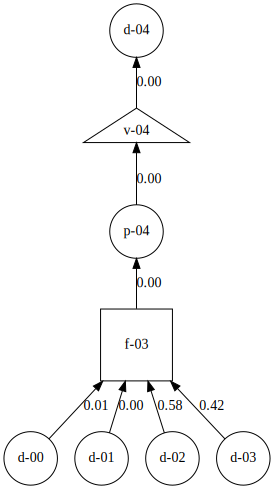

[0, 2, 3]
nominal

        Shape of X on which we vote:    (30, 3)
        


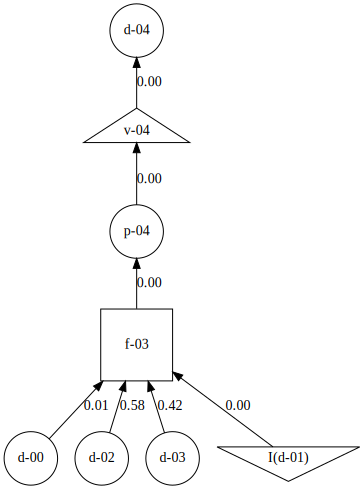

[2, 3]
nominal

        Shape of X on which we vote:    (30, 3)
        


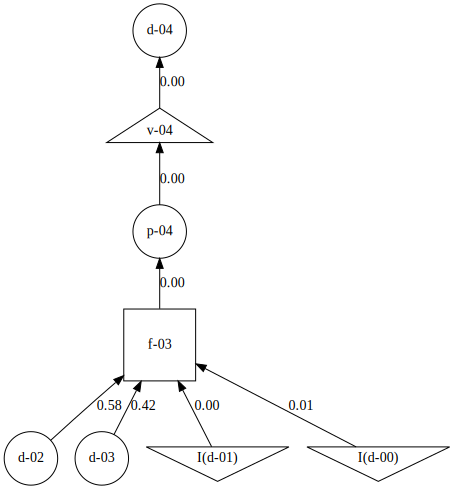

[2]
nominal

        Shape of X on which we vote:    (30, 3)
        


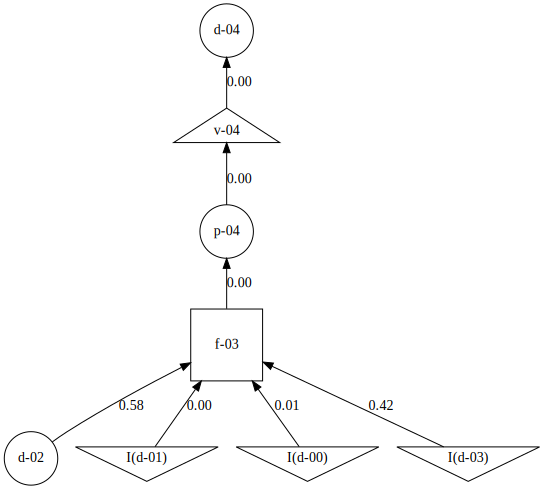

[0.9333333333333332, 0.9333333333333332, 0.9333333333333332, 0.5555555555555555]


/home/zissou/miniconda3/envs/aaai20/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [6]:
res = []
for ds in datasets:
    
    # Train
    fn_train = filename(ds, step=1, suffix='train')
    
    df = fn_to_ok_df(fn_train, return_qry=False)
    train = df.values
    target_id = list(range(df.shape[1]))[-1]
    
    m_basic = Modulo(
        random_state=RANDOM_STATE,
        prediction_algorithm="mi",
        clf_criterion="gini",
        rgr_criterion="mae",
        selection_algorithm="base",
        nb_iterations=1,
        min_samples_leaf=2,
    )

    m_basic.fit(train, nominal_attributes={target_id})
    
    # Test
    fn_qry = [os.path.join(step_dir, fn) for fn in os.listdir(step_dir) if ds in fn]
    fn_qry.sort()
    
    for q_idx, fn in enumerate(fn_qry):
        
        df_qry, q_code = fn_to_ok_df(fn, return_qry=True)
        test = df_qry.values
        y_true = test[:,target_id].copy()
        test[:, target_id] = np.nan
        
        y_pred = m_basic.predict(test, q_code=q_code)
        
        m_basic.show_q_diagram(fi=True)
        
        f1 = f1_score(y_true, y_pred, average='macro')
        res.append(f1)
    
print(res)

# Mercs SL

Using sklearn DTrees and a more sane algorithm.

[0, 1, 2, 3]
nominal

        Shape of X on which we vote:    (30, 3)
        


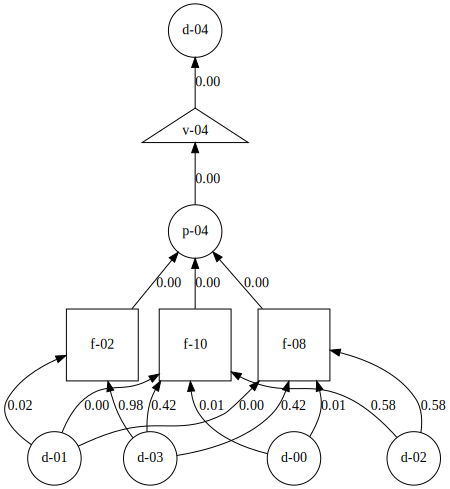

[0, 2, 3]
nominal

        Shape of X on which we vote:    (30, 3)
        


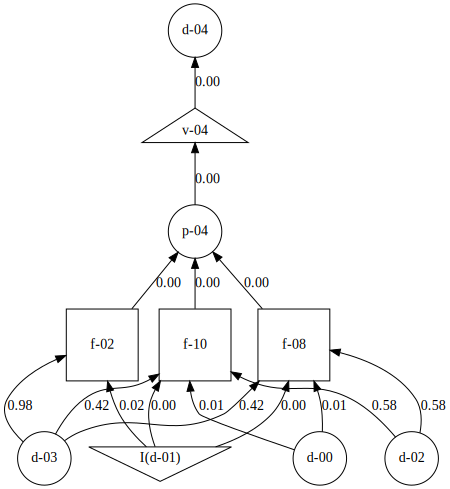

[2, 3]
nominal

        Shape of X on which we vote:    (30, 3)
        


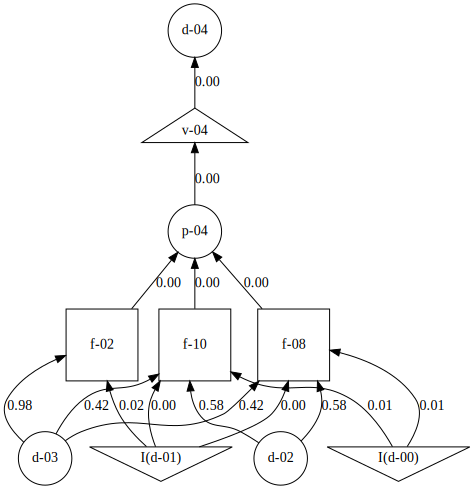

[2]
nominal

        Shape of X on which we vote:    (30, 3)
        


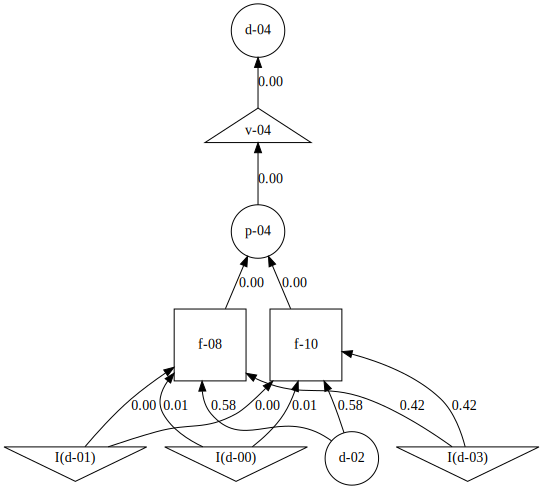

[0.9333333333333332, 0.9333333333333332, 0.9333333333333332, 0.5555555555555555]


/home/zissou/miniconda3/envs/aaai20/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [7]:
res = []
for ds in datasets:
    
    # Train
    fn_train = filename(ds, step=1, suffix='train')
    
    df = fn_to_ok_df(fn_train, return_qry=False)
    train = df.values
    target_id = list(range(df.shape[1]))[-1]
    
    m_basic = Modulo(
        random_state=RANDOM_STATE,
        prediction_algorithm="mrai",
        clf_criterion="gini",
        rgr_criterion="mae",
        selection_algorithm="random",
        fraction_missing=0.2,
        nb_iterations=3,
        min_samples_leaf=2,
    )

    m_basic.fit(train, nominal_attributes={target_id})
    
    # Test
    fn_qry = [os.path.join(step_dir, fn) for fn in os.listdir(step_dir) if ds in fn]
    fn_qry.sort()
    
    for q_idx, fn in enumerate(fn_qry):
        
        df_qry, q_code = fn_to_ok_df(fn, return_qry=True)
        test = df_qry.values
        y_true = test[:,target_id].copy()
        test[:, target_id] = np.nan
        
        y_pred = m_basic.predict(test, q_code=q_code)
        
        m_basic.show_q_diagram(fi=True)
        
        f1 = f1_score(y_true, y_pred, average='macro')
        res.append(f1)
    
print(res)

# Mercs ML

Most advanced MERCS strategy. Can we improve upon what exists. Actually, this is the experiment that should've happened years ago.

[0, 1, 2, 3]
nominal

        Shape of X on which we vote:    (30, 3)
        


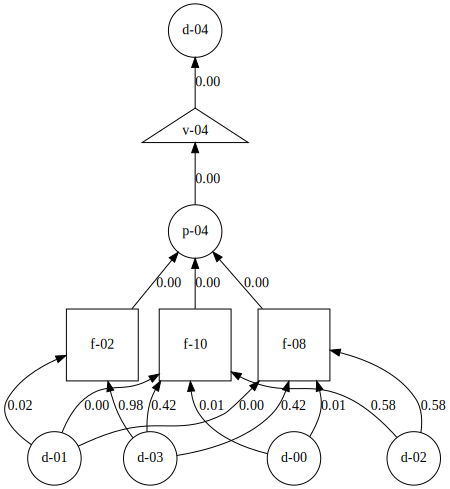

[0, 2, 3]
nominal

        Shape of X on which we vote:    (30, 3)
        


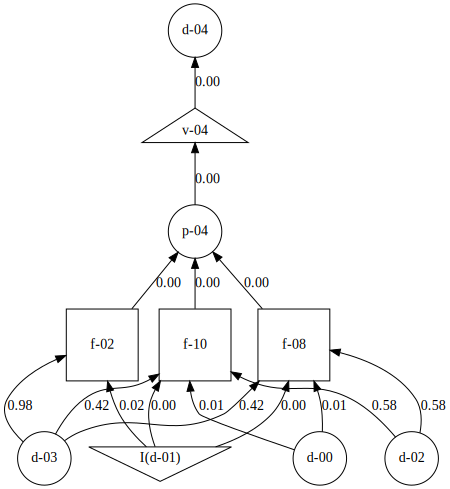

[2, 3]
nominal

        Shape of X on which we vote:    (30, 3)
        


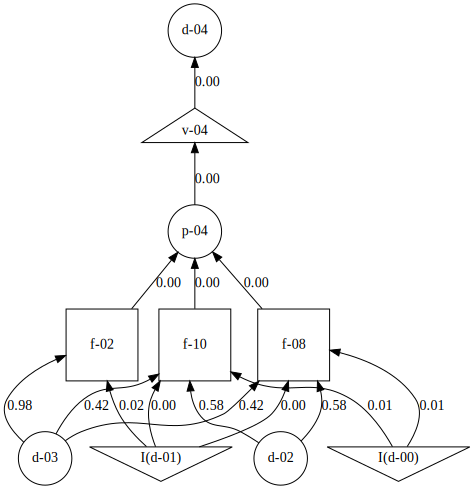

[2]
nominal

        Shape of X on which we vote:    (30, 3)
        


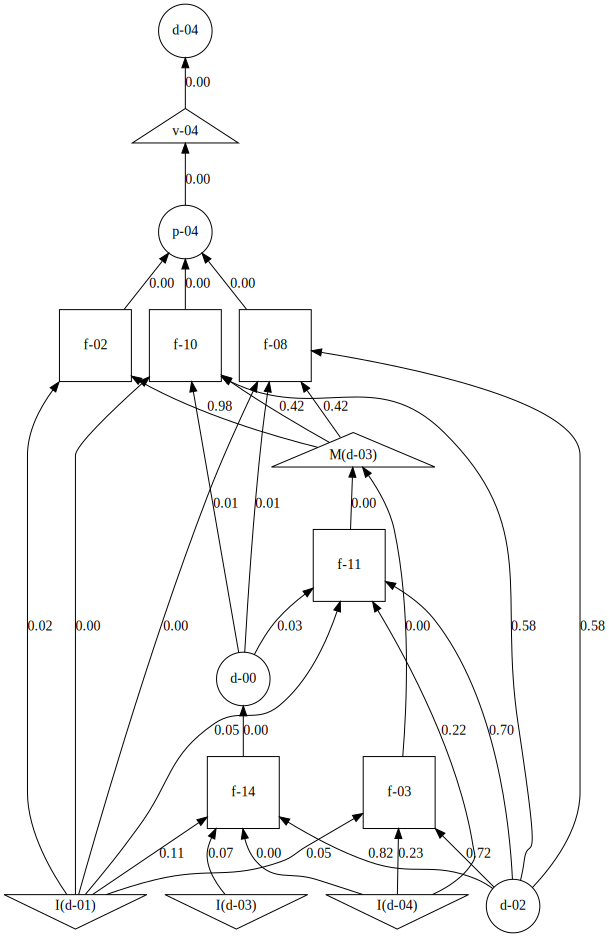

[0.9333333333333332, 0.9333333333333332, 0.9333333333333332, 0.8976982097186701]


In [8]:
res = []
for ds in datasets:
    
    # Train
    fn_train = filename(ds, step=1, suffix='train')
    
    df = fn_to_ok_df(fn_train, return_qry=False)
    train = df.values
    target_id = list(range(df.shape[1]))[-1]
    
    m_basic = Modulo(
        random_state=RANDOM_STATE,
        prediction_algorithm="it",
        clf_criterion="gini",
        rgr_criterion="mae",
        selection_algorithm="random",
        fraction_missing=0.2,
        nb_iterations=3,
        min_samples_leaf=2,
    )

    m_basic.fit(train, nominal_attributes={target_id})
    
    # Test
    fn_qry = [os.path.join(step_dir, fn) for fn in os.listdir(step_dir) if ds in fn]
    fn_qry.sort()
    
    for q_idx, fn in enumerate(fn_qry):
        
        df_qry, q_code = fn_to_ok_df(fn, return_qry=True)
        test = df_qry.values
        y_true = test[:,target_id].copy()
        test[:, target_id] = np.nan
        
        y_pred = m_basic.predict(test, q_code=q_code)
        
        m_basic.show_q_diagram(fi=True)
        
        f1 = f1_score(y_true, y_pred, average='macro')
        res.append(f1)
    
print(res)